In [10]:
#加载程序所需要的包
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from tqdm import tqdm

In [11]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8aa1cb76-f24b-8d07-a5d6-3d7391132ffb)


In [ ]:
# """
# 弄到colab/content硬碟底下讀取速度比較快

# """
# file_dir = '/content/drive/My Drive/DL/shopee-product-detection-dataset.zip'  # 你的压缩包路径
# zipFile = zipfile.ZipFile(file_dir)
# for file in zipFile.namelist():
#     zipFile.extract(file, '/content/shopee')  # 解压路径
# zipFile.close()

In [ ]:
# !cp -R ./drive/'My Drive'/iii_course/HOT/Hot/test ./

In [12]:

# 从硬盘文件夹中加载图像数据集

# 数据存储总路径
data_dir = '/content/drive/My Drive/machine learning/for data'
# 图像的大小为224*224
image_size = 100
# 从data_dir/train加载文件
# 加载的过程将会对图像自动作如下的图像增强操作：
# 1. 随机从原始图像中切下来一块224*224大小的区域
# 2. 随机水平翻转图像
# 3. 将图像的色彩数值标准化
# (os.path.join(data_dir,'honda')
train_dataset = datasets.ImageFolder(data_dir,
                                     transforms.Compose([
                                                         transforms.RandomResizedCrop(image_size),
                                                         transforms.RandomHorizontalFlip(),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                         ]))

# 加载校验数据集，对每个加载的数据进行如下处理：
# 1. 放大到256*256像素
# 2. 从中心区域切割下224*224大小的图像区域
# 3. 将图像的色彩数值标准化
val_dataset = datasets.ImageFolder(data_dir,
                                   transforms.Compose([
                                                       transforms.Resize(256),
                                                       transforms.CenterCrop(image_size),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                      ]))

# 创建相应的数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 128, shuffle = True, num_workers=4)

# 读取得出数据中的分类类别数
num_classes = len(train_dataset.classes)

# 检测本机器是否安装GPU，将检测结果记录在布尔变量use_cuda中
use_cuda = torch.cuda.is_available()

# 当可用GPU的时候，将新建立的张量自动加载到GPU中
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

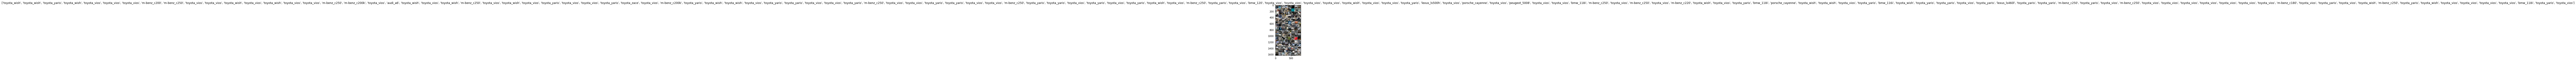

In [13]:
def imshow(inp, title=None):
    # 将一张图打印显示出来，inp为一个张量，title为显示在图像上的文字
    
    #一般的张量格式为：channels*image_width*image_height
    #而一般的图像为image_width*image_height*channels所以，需要将channels转换到最后一个维度
    inp = inp.numpy().transpose((1, 2, 0)) 
    
    #由于在读入图像的时候所有图像的色彩都标准化了，因此我们需要先调回去
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    #将图像绘制出来
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 暂停一会是为了能够将图像显示出来。


#获取第一个图像batch和标签
images, labels = next(iter(train_loader))

# 将这个batch中的图像制成表格绘制出来
out = torchvision.utils.make_grid(images)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [14]:
# 用于手写数字识别的卷积神经网络
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 5, padding = 2) #输入通道为1，输出通道为4，窗口大小为5，padding为2
        self.pool = nn.MaxPool2d(2, 2) #一个窗口为2*2的pooling运算
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #第二层卷积，输入通道为depth[0], 输出通道为depth[1]，窗口wei15，padding为2
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512) #一个线性连接层，输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为

    def forward(self, x):
        #神经网络完成一步前馈运算的过程，从输入到输出
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x, dim=1) #log_softmax可以理解为概率对数值
        return x
    
    def retrieve_features(self, x):
        #提取卷积神经网络的特征图的函数，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行10列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [15]:

# 加载网络
net = ConvNet()
# 如果有GPU就把网络加载到GPU中
net = net.cuda() if use_cuda else net
criterion = nn.CrossEntropyLoss() #Loss函数的定义
optimizer = optim.SGD(net.parameters(), lr = 0.99, momentum=0.9)

record = [] #记录准确率等数值的容器

#开始训练循环
num_epochs = 2
net.train(True) # 给网络模型做标记，标志说模型在训练集上训练
best_model = net
best_r = 0.0
for epoch in tqdm(range(num_epochs)):
    #optimizer = exp_lr_scheduler(optimizer, epoch)
    train_rights = [] #记录训练数据集准确率的容器
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(True), target.clone().detach()#data为图像，target为标签
        # 如果有GPU就把数据加载到GPU上
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data) #完成一次预测
        loss = criterion(output, target) #计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降
        right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器中
        
        #因为所有计算都在GPU中，打印的数据再加载到CPU中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

    
     #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))

    #在测试集上分批运行，并计算总的正确率
    net.eval() #标志模型当前为运行阶段
    test_loss = 0
    correct = 0
    vals = []
    #对测试数据集进行循环
    for data, target in val_loader:
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        # 如果GPU可用，就把数据加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data) #将特征数据喂入网络，得到分类的输出
        val = rightness(output.cuda(), target.cuda()) #获得正确样本数以及总样本数
        vals.append(val) #记录结果

    #计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0]/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].cpu().numpy() / train_r[1], 100. * val_r[0].cpu().numpy()/val_r[1]))       
    record.append([np.mean(train_losses), train_r[0].cpu().numpy() / train_r[1], val_r[0].cpu().numpy()/val_r[1]])

 50%|█████     | 1/2 [04:44<04:44, 284.03s/it]

训练周期: 0 	Loss: 2.106235	训练正确率: 26.78%, 校验正确率: 27.20%


100%|██████████| 2/2 [09:28<00:00, 284.24s/it]

训练周期: 1 	Loss: 1.914373	训练正确率: 27.88%, 校验正确率: 27.20%


In [16]:
#在测试集上分批运行，并计算总的正确率
net.eval() #标志模型当前为运行阶段
test_loss = 0
correct = 0
vals = []

#对测试数据集进行循环
for data, target in val_loader:
    data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    output = net(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].cpu().numpy() / rights[1]
right_rate

0.2720306513409962

Text(0, 0.5, 'Error Rate')

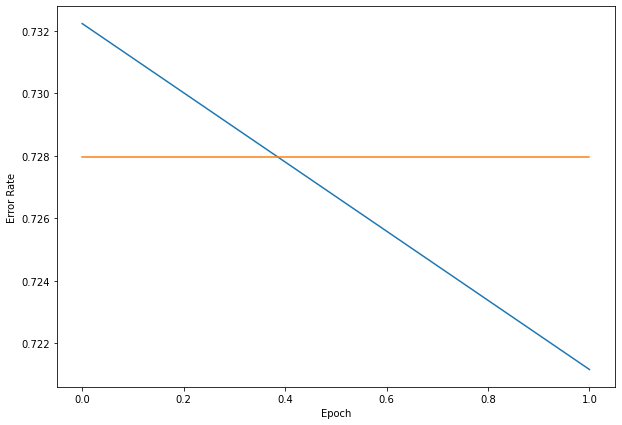

In [17]:
# 绘制误差率曲线
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
#plt.plot(x)
plt.figure(figsize = (10, 7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

In [18]:

# 加载模型库中的residual network，并设置pretrained为true，这样便可加载相应的权重,下載模型
net = models.resnet18(pretrained=True)
#如果存在GPU，就将网络加载到GPU上
net = net.cuda() if use_cuda else net
# 将网络的架构打印出来
net

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

NameError: ignored

In [19]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [20]:
# 读取最后线性层的输入单元数，这是前面各层卷积提取到的特征数量
num_ftrs = net.fc.in_features

# 重新定义一个全新的线性层，它的输出为2，原本是1000
net.fc = nn.Linear(num_ftrs, 2)

#如果存在GPU则将网络加载到GPU中
net.fc = net.fc.cuda() if use_cuda else net.fc

criterion = nn.CrossEntropyLoss() #Loss函数的定义
# 将网络的所有参数放入优化器中
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum=0.9)

record = [] #记录准确率等数值的容器

#开始训练循环
num_epochs = 1
net.train(True) # 给网络模型做标记，标志说模型在训练集上训练
best_model = net
best_r = 0.0
for epoch in range(num_epochs):
    #optimizer = exp_lr_scheduler(optimizer, epoch)
    train_rights = [] #记录训练数据集准确率的容器
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach() #data为图像，target为标签
        #如果存在GPU则将变量加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data) #完成一次预测
        loss = criterion(output, target) #计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降
        right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器中
        loss = loss.cpu() if use_cuda else loss
        train_losses.append(loss.data.numpy())

    
        #if batch_idx % 20 == 0: #每间隔100个batch执行一次
     #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))

    #在测试集上分批运行，并计算总的正确率
    net.eval() #标志模型当前为运行阶段
    test_loss = 0
    correct = 0
    vals = []
    #对测试数据集进行循环
    for data, target in val_loader:
        #如果存在GPU则将变量加载到GPU中
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = data.clone().detach().requires_grad_(True), target.clone().detach()
        output = net(data) #将特征数据喂入网络，得到分类的输出
        val = rightness(output.cuda(), target.cuda()) #获得正确样本数以及总样本数
        vals.append(val) #记录结果

    #计算准确率
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0].numpy()/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].cpu().numpy() / train_r[1], 100. * val_r[0].cpu().numpy()/val_r[1]))       
    record.append([np.mean(train_losses), train_r[0].cpu().numpy() / train_r[1], val_r[0].cpu().numpy()/val_r[1]])


RuntimeError: ignored

In [ ]:
# 打印误差率曲线
x = [x[0] for x in record]
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
#plt.plot(x)
plt.figure(figsize = (10, 7))
plt.plot(y)
plt.plot(z)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

In [ ]:
# 将预训练的模型用语测试数据，打印其分类效果
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(15,10))

    for i, data in enumerate(val_loader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot( 2,num_images//2, images_so_far)
            ax.axis('off')
            
            ax.set_title('predicted: {}'.format(val_dataset.classes[preds[j]]))
            imshow(data[0][j])

            if images_so_far == num_images:
                return
visualize_model(net)

plt.ioff()
plt.show()